# Approximative replication of SAPS II

Here we combine the queries detailled in omop_sapsii_components to compute an approximation of the OMOP simplified acute physiology score II (SAPS II) calculated with MIMIC here:

https://github.com/MIT-LCP/mimic-code/blob/master/concepts/severityscores/sapsii.sql

In a clearer fashion, one could refer to one of the links below to get an immediate understanding of the score:

- http://clincalc.com/icumortality/sapsii.aspx

- http://www.sfar.org/scores/igs2_expanded.php (in French)

First, we'll need to extract an individual (see : https://github.com/dataforgoodfr/batch4_diafoirus_fleming/blob/master/omop_create%20dataset.ipynb) through our home-made lib.


In [1]:
# Add private path to 'batch4_diafoirus_fleming'
import __init__

[INFO] adding /Users/jeremydesir/Desktop/DataForGood/batch4_diafoirus_fleming to sys.path


In [2]:
import os
import sys

In [3]:
# Load external librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Load internal librairies
from fleming_lib.tools import connect_to_omop
from fleming_lib.dataset import create_dataset
from fleming_lib.severity_scores import compute_sapsii_score

from fleming_lib.metrics import add_target, add_age


In [4]:
# Access the DB
conn = connect_to_omop()

Now we'll consider a patient who died during its stay and compute its dynamic (approximated) SAPS II 

In [5]:
# Define list of patients
single_id = 62063368
list_patients = [single_id]

# Create dataset
dataset = create_dataset(conn, list_patients=list_patients, n_patients_per_batch=10, verbose=True)

Batch 1/1 - Done                                                                                     [104 s     ]


/Users/jeremydesir/Desktop/DataForGood/batch4_diafoirus_fleming/fleming_lib/dataset.py:248: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  dataset = dataset.reindex_axis(frame[0].columns, axis=1)


In [6]:
tmp = dataset.copy(deep=True)

In [7]:
print("Data Frame shape")
print(dataset.shape)

Data Frame shape
(609, 117)


Convert the body temperature into °C

In [8]:
dfBodyTempC = dataset['Body temperature'].copy()
dfBodyTempC = pd.DataFrame([(tempF-32.0)/1.8 if tempF>65 else tempF for tempF in dfBodyTempC.values], index = dataset.index)
dataset = dataset.assign(bodyTemperature_C = dfBodyTempC.values)

In [9]:
# Set relative time scale
start_date = dataset['measurement_datetime'][0]
dataset['measurement_datetime'] -= start_date

In [45]:
# Let's set the index with measurement_datetime 
dataset.set_index('measurement_datetime', inplace = True)

In [46]:
tempRelevantComponents = dataset[['age', 'Glasgow coma scale', 'BP systolic', 'bodyTemperature_C']]
#relevantComponents.dropna(inplace=True)
tempRelevantComponentsScore = tempRelevantComponents.apply(compute_sapsii_score, axis=1)

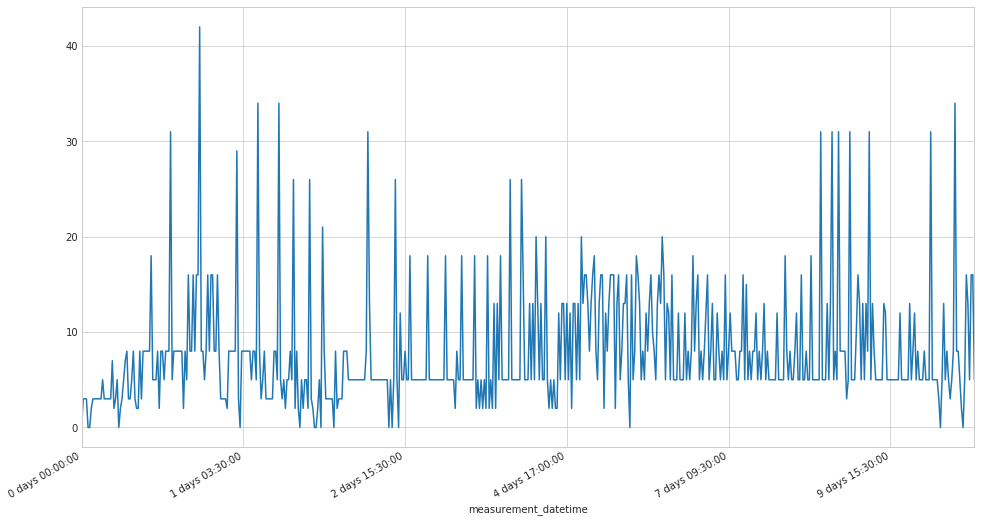

In [62]:
tempRelevantComponentsScore.plot(figsize=(16,9))

In [ ]:
# http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_apply.html for a rolling score